<a href="https://colab.research.google.com/github/alvaroderas/waste-classifier/blob/main/waste_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

uploaded = files.upload()

import zipfile
import io

with zipfile.ZipFile(io.BytesIO(uploaded['archive.zip']), 'r') as zip_ref:
    zip_ref.extractall('../')

Saving archive.zip to archive.zip


In [ ]:
"""
Contains functionality for setting up image classifcation data through
the creation of PyTorch DataLoaders.

Author: Alvaro Deras
Date: January 13, 2024
"""
import os, torchvision

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32

data_root = "/content/dataset"


def setup_data(data_root: str="/content/dataset",
               batch_size: int=BATCH_SIZE,
               num_workers: int=NUM_WORKERS):
    """
    Returns a tuple of dataloaders and class names.

    Takes in training and test datasets and converts them into PyTorch DataLoaders.

    Parameter data_root: the root directory where the dataset is located
    Precondition: data_root is a valid path

    Parameter batch_size: the number of samples per batch in each DataLoader
    Precondition: batch_size is an int

    Parameter num_workers: the number of workers per DataLoader
    Precondition: num_workers is an int
    """
    data_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

    train_data = datasets.ImageFolder(
        root=os.path.join(data_root, "DATASET/TRAIN"),
        transform=data_transform,
    )

    test_data = datasets.ImageFolder(
        root=os.path.join(data_root, "DATASET/TEST"),
        transform=data_transform,
    )

    class_names = train_data.classes

    train_dataloader = DataLoader(
        dataset=train_data,
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )

    test_dataloader = DataLoader(
        dataset=test_data,
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )

    return train_dataloader, test_dataloader, class_names

In [ ]:
"""
Contains PyTorch code to instantiate a convolutional neural network model.

Author: Alvaro Deras
Date: January 13, 2024
"""
import torch
from torch import nn

class WasteClassifier(nn.Module):
    """
    A class representing a convolutional neural network model.
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        """
        Instantiates an instance of the WasteClassifier model.

        Parameter input_shape: the number of input channels
        Precondition: input_shape is an int

        Parameter hidden_units: the number of hidden units between layers
        Precondition: hidden_units is an int

        Parameter output_shape:
        Precondition: output_shape is an int
        """
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                    out_channels=hidden_units,
                    kernel_size=3,
                    stride=1,
                    padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 16 * 16,
                      out_features=1)
        )
    def forward(self, x: torch.Tensor):
        """
        Returns the output of the model

        Parameter x: the initial input data
        Precondition: x is an instance of torch.Tensor
        """

        x = self.conv_block_1(x)
        #print(f"Output shape of conv_block_1: {x.shape}")
        x = self.conv_block_2(x)
        #print(f"Output shape of conv_block_2: {x.shape}")
        x = self.classifier(x)
        #print(f"Output shape of classifier: {x.shape}")
        return x

In [ ]:
"""
Contains functions for training and testing a PyTorch model.

Author: Alvaro Deras
Date: January 13, 2024
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """
    Returns a tuple of training loss and training accuracy metrics.

    Trains a given PyTorch model for an epoch by converting model to training
    mode and proceeds to undergo training steps.

    Parameter model: the model to be trained
    Precondition: model is an instance of torch.nn.Module

    Parameter dataloader: the dataloader iterable for the dataset
    Precondition: dataloader is an instance of torch.utils.data.DataLoader

    Parameter loss_function: the loss function used for optimization
    Precondition: loss_function is an instance of torch.nn.Module

    Parameter optimizer: the optimizer used for updating model parameters
    Precondition: optimizer is an instance of torch.optim.Optimizer

    Parameter device: the target device to compute on (e.g. "cuda" or "cpu")
    Precondition: device is a valid torch.device
    """
    model.train()

    model.to(device)

    train_loss = 0
    train_acc = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y.view(-1).long()
        y = y.to(device)

        y_logits = model(X).squeeze().to(device)

        loss = loss_function(y_logits, y.type(torch.float32))
        train_loss += loss.item()

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        y_pred_class = torch.round(torch.sigmoid(y_logits))
        train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc


def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_function: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """
    Returns a tuple of testing loss and testing accuracy metrics.

    Tests a given PyTorch model for an epoch by converting model to evaluation
    mode and undergoes testing steps.

    Parameter model: the model to be trained
    Precondition: model is an instance of torch.nn.Module

    Parameter dataloader: the dataloader iterable for the dataset
    Precondition: dataloader is an instance of torch.utils.data.DataLoader

    Parameter loss_function: the loss function used for optimization
    Precondition: loss_function is an instance of torch.nn.Module

    Parameter device: the target device to compute on (e.g. "cuda" or "cpu")
    Precondition: device is a valid torch.device
    """
    model.eval()
    test_loss = 0
    test_acc = 0

    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X = X.to(device)
            y = y.to(device)

            test_pred_logits = model(X).squeeze()

            loss = loss_function(test_pred_logits, y.float())
            test_loss += loss.item()

            test_pred_labels = torch.round(torch.sigmoid(test_pred_logits))
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc


def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          loss_function: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """
    Returns a dictionary of training and testing metrics.

    Trains and tests a PyTorch model by combining train_step() and test_step()
    functions for a given number of epochs.

    Parameter model: the model to be trained
    Precondition: model is an instance of torch.nn.Module

    Parameter train_dataloader: the dataloader iterable for the dataset
    Precondition: train_dataloader is an instance of torch.utils.data.DataLoader

    Parameter test_dataloader: the dataloader iterable for the dataset
    Precondition: test_dataloader is an instance of torch.utils.data.DataLoader

    Parameter loss_function: the loss function used for optimization
    Precondition: loss_function is an instance of torch.nn.Module

    Parameter optimizer: the optimizer used for updating model parameters
    Precondition: optimizer is an instance of torch.optim.Optimizer

    Parameter epochs: the amount of epochs to undergo training
    Precondition: epochs is an int greater or equal to 1

    Parameter device: the target device to compute on (e.g. "cuda" or "cpu")
    Precondition: device is a valid torch.device
    """
    metrics = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc":[]}

    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_function=loss_function,
                                           optimizer=optimizer,
                                           device=device)
        test_loss, test_acc = test_step(model=model,
                                        dataloader=test_dataloader,
                                        loss_function=loss_function,
                                        device=device)
        print(
            f"Epoch: {epoch+1} |"
            f"train_loss: {train_loss:.4f} |"
            f"train_acc: {train_acc:.4f} |"
            f"test_loss: {test_loss:.4f} |"
            f"test_acc: {test_acc:.4f}"
        )

        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)

    return metrics

In [ ]:
"""
Contains utility functionality for a PyTorch model.

Author: Alvaro Deras
Date: January 13, 2024
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_directory: str,
               model_name: str):
    """
    Saves a PyTorch model to target directory.

    Parameter model: the model to save
    Precondition: model is an instance of torch.nn.Module

    Parameter target_directory: the directory for the model to be saved in
    Precondition: target_directory is a string

    Parameter model_name: the filename for the model
    Precondition:  model_name is a string that ends in '.pth' or '.pt'
    """
    assert model_name.endswith('.pth') or model_name.endswith('.pt'), 'invalid model name'

    directory_path = Path(target_directory)
    directory_path.mkdir(parents=True, exist_ok=True)

    model_save_path = directory_path / model_name

    print(f"Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)


In [ ]:
import os
import torch

from torchvision import transforms

NUM_EPOCHS = 25
HIDDEN_UNITS = 32
LEARNING_RATE = 0.0003

device = "cuda" if torch.cuda.is_available() else "cpu"

train_dataloader, test_dataloader, class_names = setup_data()

model = WasteClassifier(
    input_shape=3,
    hidden_units=HIDDEN_UNITS,
    output_shape=len(class_names)
).to(device)

loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=LEARNING_RATE)

results = train(model=model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_function=loss_function,
            optimizer=optimizer,
            epochs=NUM_EPOCHS,
            device=device)
print(results)


  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 0.4617 |train_acc: 0.7878 |test_loss: 0.3154 |test_acc: 0.8834
Epoch: 2 |train_loss: 0.4016 |train_acc: 0.8226 |test_loss: 0.4065 |test_acc: 0.8384
Epoch: 3 |train_loss: 0.3726 |train_acc: 0.8422 |test_loss: 0.2874 |test_acc: 0.8905
Epoch: 4 |train_loss: 0.3533 |train_acc: 0.8511 |test_loss: 0.2902 |test_acc: 0.8917
Epoch: 5 |train_loss: 0.3415 |train_acc: 0.8581 |test_loss: 0.3575 |test_acc: 0.8641
Epoch: 6 |train_loss: 0.3273 |train_acc: 0.8634 |test_loss: 0.2615 |test_acc: 0.9031
Epoch: 7 |train_loss: 0.3187 |train_acc: 0.8694 |test_loss: 0.3202 |test_acc: 0.8893
Epoch: 8 |train_loss: 0.3121 |train_acc: 0.8724 |test_loss: 0.3475 |test_acc: 0.8816
Epoch: 9 |train_loss: 0.3040 |train_acc: 0.8773 |test_loss: 0.3064 |test_acc: 0.9012
Epoch: 10 |train_loss: 0.2952 |train_acc: 0.8834 |test_loss: 0.2536 |test_acc: 0.9127
Epoch: 11 |train_loss: 0.2909 |train_acc: 0.8846 |test_loss: 0.2982 |test_acc: 0.8933
Epoch: 12 |train_loss: 0.2847 |train_acc: 0.8860 |test_loss: 0.

In [ ]:
pip install seaborn

Making predictions...:   0%|          | 0/63 [00:00<?, ?it/s]

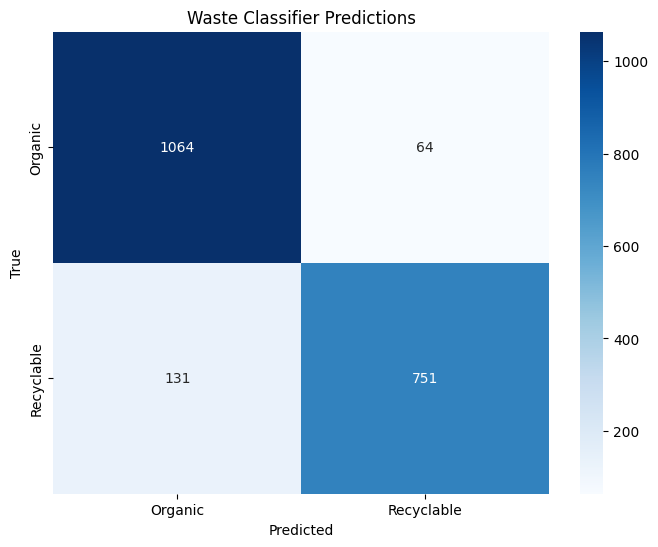

In [ ]:
import numpy as np
from torch.utils.data import DataLoader, random_split, SubsetRandomSampler


data_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
    ])

test_data = datasets.ImageFolder(
    root=os.path.join(data_root, "DATASET/TEST"),
    transform=data_transform,
)

test_indices = list(range(len(test_data)))

random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

shuffle_dataset = True
if shuffle_dataset:
    np.random.shuffle(test_indices)


test_split = 0.8
test_size = int(np.floor(test_split * len(test_data)))
test_indices, _ = test_indices[:test_size], test_indices[test_size:]


test_sampler = SubsetRandomSampler(test_indices)


test_dataloader = DataLoader(
    dataset=test_data,
    batch_size=BATCH_SIZE,
    sampler=test_sampler,
    num_workers=os.cpu_count(),
    pin_memory=True
)


y_preds = []
true_labels = []
model.eval()

threshold = 0.5

with torch.inference_mode():
    for X, y in tqdm(test_dataloader, desc="Making predictions..."):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = (y_logit> threshold).long()
        y_preds.append(y_pred.cpu())
        true_labels.append(y.cpu())

y_pred_tensor = torch.cat(y_preds)
true_labels_tensor = torch.cat(true_labels)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["Organic", "Recyclable"]


true_labels_np = true_labels_tensor.numpy()
y_pred_np = y_pred_tensor.numpy()

cm = confusion_matrix(true_labels_np, y_pred_np)


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Waste Classifier Predictions")
plt.show()
